Introduction to automatic differentiation with jax
==================================================



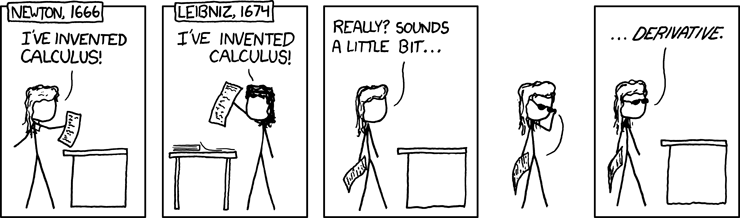

[src](https://xkcd.com/626/)



## Derivatives in scientific programming





Derivatives play an important role in modeling engineering processes.
They serve mathematical roles in optimization where we need them to find
stationary points (i.e. where the first derivatives are zero), and to
determine if these points are minima, maxima or saddle points.

Derivatives also play a central role in uncertainty propagation and
sensitivity analysis. These analyses require derivatives of equations
with respect to parameters.

Derivatives also serve in physical roles. When we write mass/energy
balances we are defining how those variables change in time, which is a
derivative. If you recall Fick's law, we way that the flux of a material
is proportional to the *gradient* in concentration, which is a
derivative. In thermodynamics, we relate many properties to derivatives
of some thermodynamic variable. For example, the heat capacity is
defined by a partial derivative of the enthalpy:
$\left(\frac{\partial H}{\partial T}\right)_P = C_p$. There are many
more examples where derivatives are important.

We usually think about deriving derivatives using calculus. That
requires, however, that you have an analytical equation, that you know
how to derive the derivative, and finally that you correctly evaluate
the result. When you have an analytical equation, that approach is
probably the best one when done correctly.

In many cases, however, we may not have an equation, or the equation
could change regularly or be tedious to derive the derivative. As we
increasingly express equations in the form of a program, it is
increasingly inconvenient and difficult to work through the program to
derive derivatives. In these cases, we need a computational approach to
getting derivatives.

We have primarily considered two approaches to *estimating* or
*approximating* derivatives so far:

1.  `numpy.gradient`
2.  `scipy.misc.derivative`

Both of these approaches have limitations we review below.





#### numpy.gradient





`numpy.gradient` uses
[finite
difference](https://en.wikipedia.org/wiki/Numerical_differentiation) formulas to estimate the derivatives *from data*. This data
may be obtained from experiments, or by numeric integration of an ODE,
or from the solution to a BVP. In these cases we do not have analytical
formulas to get derivatives from, and we have to resort to numerical
methods.





In [1]:
import matplotlib.pyplot as plt
import numpy as np

?np.gradient



Signature: np.gradient(f, *varargs, axis=None, edge_order=1)
Docstring:
Return the gradient of an N-dimensional array.

The gradient is computed using second order accurate central differences
in the interior points and either first or second order accurate one-sides
(forward or backwards) differences at the boundaries.
The returned gradient hence has the same shape as the input array.

Parameters
----------
f : array_like
    An N-dimensional array containing samples of a scalar function.
varargs : list of scalar or array, optional
    Spacing between f values. Default unitary spacing for all dimensions.
    Spacing can be specified using:

    1. single scalar to specify a sample distance for all dimensions.
    2. N scalars to specify a constant sample distance for each dimension.
       i.e. `dx`, `dy`, `dz`, ...
    3. N arrays to specify the coordinates of the values along each
       dimension of F. The length of the array must match the size of
       the corresponding dimensio

The accuracy of these derivatives depends on the spacing between the
data points. We have seen the derivatives at the edges of the data are
less accurate because a first-order equation is used by default.





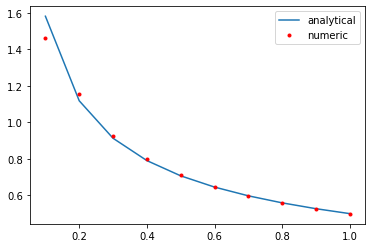

In [8]:
x = np.linspace(0.1, 1, 10)
y = x**0.5

plt.plot(x, 0.5 * x**-0.5, x, np.gradient(y, x, edge_order=2), "r.")
plt.legend(["analytical", "numeric"]);



You may recall we can fit a polynomial to this data, and then easily get
the derivative of the polynomial. By increasing the polynomial order we
can improve the derivative estimates to a point. If you start
overfitting, you will introduce wiggles into the data.





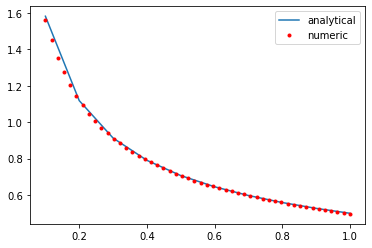

In [17]:
p = np.polyfit(x, y, 8)
dp = np.polyder(p)

xfit = np.linspace(0.1, 1.0)
plt.plot(x, 0.5 * x**-0.5, xfit, np.polyval(dp, xfit), "r.")
plt.legend(["analytical", "numeric"]);



Let's briefly review some linear algebra and the connection with
derivatives.

A central difference formula is:

$y'(x_i) \approx \frac{y_{i+1} - y_{i-1}}{2h}$

We cannot evaluate this for $y_0$ or $y_{-1}$. We need a simpler formula for
that:

We use a forward formula at the beginning:
$y'(x_0) \approx \frac{y_1 - y_0}{h}$

and a backward formula at the end:
$y'(x_{-1}) \approx \frac{y_{-1} - y_{-2}}{h}$

We can express these formulas in matrix algebra form:

$\mathbf{y'} = \mathbf{D} \mathbf{y}$



In [33]:
x, h = np.linspace(0.1, 1, 10, retstep=True)
print(h)
y = x**0.5

D = np.zeros((len(x), len(x)))
D += np.diag(np.ones(len(x) - 1) / (2 * h), 1)  # diagonal above main
D += np.diag(-np.ones(len(x) - 1) / (2 * h), -1)  #  diagonal below the main
D[0, 0:2] = np.array([-1, 1]) / h  # forward formula for the first row
D[-1, -2:] = np.array([-1, 1]) / h  # backward formula for the last row
D



0.1


array([[-10.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ -5.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,  -5.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  -5.,   0.,   5.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  -5.,   0.,   5.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  -5.,   0.,   5.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  -5.,   0.,   5.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  -5.,   0.,   5.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  -5.,   0.,   5.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  10.]])

In [34]:
dydx = D @ y

np.allclose(dydx, np.gradient(y, x, edge_order=1))

True

In [35]:
dydx, np.gradient(y, x, edge_order=1)

(array([1.30985829, 1.15747396, 0.92620968, 0.79692112, 0.71070569,
        0.64776623, 0.59915261, 0.56011636, 0.52786405, 0.51316702]),
 array([1.30985829, 1.15747396, 0.92620968, 0.79692112, 0.71070569,
        0.64776623, 0.59915261, 0.56011636, 0.52786405, 0.51316702]))

In [29]:
??np.gradient



Signature: np.gradient(f, *varargs, axis=None, edge_order=1)
Source:   
@array_function_dispatch(_gradient_dispatcher)
def gradient(f, *varargs, axis=None, edge_order=1):
    """
    Return the gradient of an N-dimensional array.

    The gradient is computed using second order accurate central differences
    in the interior points and either first or second order accurate one-sides
    (forward or backwards) differences at the boundaries.
    The returned gradient hence has the same shape as the input array.

    Parameters
    ----------
    f : array_like
        An N-dimensional array containing samples of a scalar function.
    varargs : list of scalar or array, optional
        Spacing between f values. Default unitary spacing for all dimensions.
        Spacing can be specified using:

        1. single scalar to specify a sample distance for all dimensions.
        2. N scalars to specify a constant sample distance for each dimension.
           i.e. `dx`, `dy`, `dz`, ...
    

There are more accurate formulas to use for these that use more data
points, but in these cases it is better to use `np.gradient` because it
already handles these.





#### scipy.misc.derivative





When we have equations in the form of *functions* rather than data, we
can leverage `scipy.misc.derivative`. This function also works by using
finite differences, and so it would suffer from the same limitations on
accuracy as we saw above with data. Nevertheless, if you don't have a
better approach, it might still be useful.





In [36]:
import numpy as np
from scipy.misc import derivative

?derivative



Signature: derivative(func, x0, dx=1.0, n=1, args=(), order=3)
Docstring:
Find the nth derivative of a function at a point.

Given a function, use a central difference formula with spacing `dx` to
compute the nth derivative at `x0`.

Parameters
----------
func : function
    Input function.
x0 : float
    The point at which the nth derivative is found.
dx : float, optional
    Spacing.
n : int, optional
    Order of the derivative. Default is 1.
args : tuple, optional
    Arguments
order : int, optional
    Number of points to use, must be odd.

Notes
-----
Decreasing the step size too small can result in round-off error.

Examples
--------
>>> from scipy.misc import derivative
>>> def f(x):
...     return x**3 + x**2
>>> derivative(f, 1.0, dx=1e-6)
4.9999999999217337
File:      /opt/tljh/user/lib/python3.9/site-packages/scipy/misc/_common.py
Type:      function


The most crucial step is choosing an appropriate value for dx. Note that
`derivative` does not return a function; we have to *wrap* it in a
function definition to use it like a function.





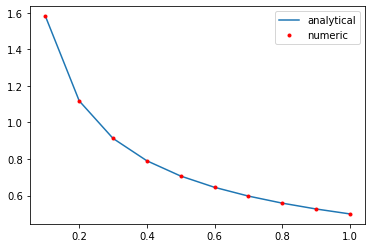

In [39]:
def f(x):
    return x**0.5


def dfdx(x, dx=1e-5):
    return derivative(f, x, dx)


plt.plot(x, 0.5 * x**-0.5, x, dfdx(x, dx=1e-5), "r.")
plt.legend(["analytical", "numeric"]);



In [ ]:
derivative(f, x, 0.005)  # this is vectorized, so the helper function is not critical here



We can combine the ideas for data and functions with
`scipy.interpolate.interp1d`. This is similar in spirit to using
polyfit, but the polynomials are locally fit rather than globally fit
through all the data points. As with polyfit, this can result in
spurious wiggles being introduced, especially near data points where
there are big changes.





In [40]:
from scipy.interpolate import interp1d

?interp1d



Init signature:
interp1d(
    x,
    y,
    kind='linear',
    axis=-1,
    copy=True,
    bounds_error=None,
    fill_value=nan,
    assume_sorted=False,
)
Docstring:     
Interpolate a 1-D function.

`x` and `y` are arrays of values used to approximate some function f:
``y = f(x)``. This class returns a function whose call method uses
interpolation to find the value of new points.

Parameters
----------
x : (N,) array_like
    A 1-D array of real values.
y : (...,N,...) array_like
    A N-D array of real values. The length of `y` along the interpolation
    axis must be equal to the length of `x`.
kind : str or int, optional
    Specifies the kind of interpolation as a string or as an integer
    specifying the order of the spline interpolator to use.
    The string has to be one of 'linear', 'nearest', 'nearest-up', 'zero',
    'slinear', 'quadratic', 'cubic', 'previous', or 'next'. 'zero',
    'slinear', 'quadratic' and 'cubic' refer to a spline interpolation of
    zeroth, first, 

In [41]:
x, h = np.linspace(0.1, 1, 10, retstep=True)
y = x**0.5 + np.random.normal(0, 0.005, size=x.shape)

af = interp1d(x, y, kind="cubic", bounds_error=False, fill_value="extrapolate")
af([0.4, 0.5]), af(3)



(array([0.64010929, 0.70019994]), array(5.49010931))

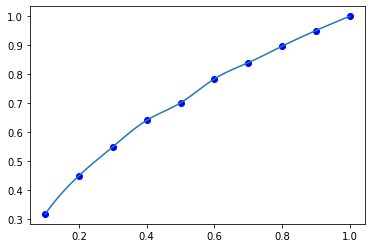

In [42]:
xfit = np.linspace(0.1, 1, 100)
plt.plot(x, y, "bo", xfit, af(xfit));



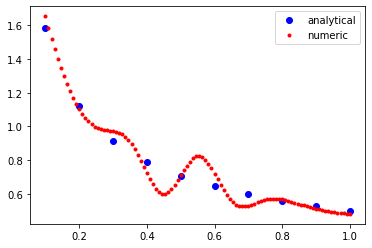

In [43]:
def dfadx(x, dx):
    return derivative(af, x, dx)


plt.plot(x, 0.5 * x**-0.5, "bo", xfit, dfadx(xfit, dx=0.05), "r.")
plt.legend(["analytical", "numeric"]);



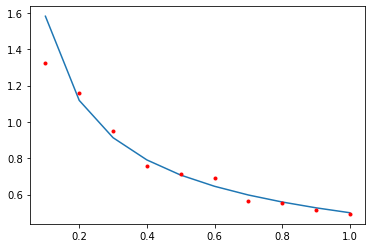

In [44]:
plt.plot(x, 0.5 * x**-0.5, x, np.gradient(y, x), "r.");



#### Limitations of numeric derivatives





There are several limitations of numeric derivatives. The biggest one is
that they are all *approximations* to the real derivative, and their
accuracy depends on how small the spacing between the data points is. If
the spacing is too small, however, these methods can suffer from
numerical instabilities. These issues are exacerbated with higher order
derivatives; derivatives tend to magnify errors in data.

Fitting models to the data leads to analytical models that can be
analytically differentiated. Here you have to be aware of the properties
of the model, and its derivatives.

The methods above apply to scalar functions of a single variable. It is
not convenient to use them for multivariable functions.

Numdifftools ([https://numdifftools.readthedocs.io/en/latest/](https://numdifftools.readthedocs.io/en/latest/)) is a
more advanced library for numerical differentiation that can do
multivariable functions, but it too can have numerical instabilities and
needs to be checked for convergence.





### Symbolic differentiation





[https://docs.sympy.org/latest/tutorial/calculus.html](https://docs.sympy.org/latest/tutorial/calculus.html)

Computer algebra systems have increasingly been able to compute symbolic
derivatives of expressions.
[sympy](https://docs.sympy.org/latest/index.html) can do some
[calculus](https://docs.sympy.org/latest/tutorial/calculus.html),
including taking derivatives symbolically.





0.5/x**0.5
0.707106781186548


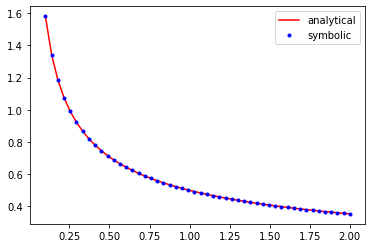

In [45]:
from sympy import *  # this is considered lazy/sloppy

x = symbols("x")

df = diff(x**0.5, x)
print(df)
print(df.subs(x, 0.5))

X = np.linspace(0.1, 2)
plt.plot(X, 0.5 * X**-0.5, "r-", X, [df.subs(x, a) for a in X], "b.")
plt.legend(["analytical", "symbolic"]);



0.5/x**0.5
0.707106781186548


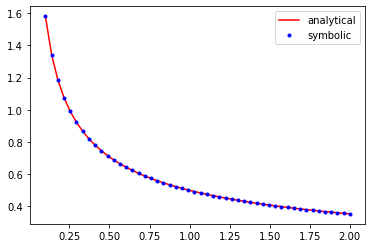

In [46]:
import sympy as sym  # This is a more responsible way to keep functions in namespaces

x = sym.symbols("x")

df = sym.diff(x**0.5, x)
print(df)
print(df.subs(x, 0.5))

X = np.linspace(0.1, 2)
plt.plot(X, 0.5 * X**-0.5, "r-", X, [df.subs(x, a) for a in X], "b.")
plt.legend(["analytical", "symbolic"]);



For some applications, this is very useful. Symbolic derivatives do not
work on programs though, and in some cases there are not simple
derivatives to find.





### Automatic differentiation





The third kind of computational derivatives we need to know about is
called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) (AD). It is completely different from both finite
differences and symbolic differentiation. In AD, we use the chain rule
to take derivatives of computer programs.

AD solves many of the problems described above:

1.  It is not an approximation like the finite difference approach.
2.  It works on programs, unlike symbolic differentiation

However, these features come at some cost; we have to use an AD library
and learn how to write code with it. Most importantly, AD is usually an
add-on feature and its implementation introduces some constraints on
what can be programmed.

There are several AD frameworks available in Python that have been
developed for machine learning applications. The main ones in use today
are:

1.  autograd - [https://github.com/HIPS/autograd](https://github.com/HIPS/autograd)
2. JAX - [https://github.com/google/jax](https://github.com/google/jax)
2.  Tensorflow - [https://www.tensorflow.org/](https://www.tensorflow.org/)
3.  pytorch - [https://pytorch.org/](https://pytorch.org/)

We will focus on jax for the rest of the semester.



jax works by modifying `numpy` so that derivatives can be
automatically computed.

**The most important step** in using jax is to import the jax
version of numpy. Not doing this will lead to errors eventually. We also configure jax to use 64-bit floats (32-bit is the default, and that is not usually sufficient for pycse calculations.)





```{note}
Super important block of code
```

In [1]:
import jax
jax.__file__

'/opt/tljh/user/lib/python3.9/site-packages/jax/__init__.py'

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as np

#### Derivatives of scalar functions





jax provides functions for getting the derivatives of different kinds of functions. We first consider scalar functions, i.e. functions that return one number that is continuous (e.g. it is a float). The function can have many arguments, but it can only return one number. Note you have to be careful here, some functions return a single number with single arguments, but return an array of numbers if you use arrays as arguments.



In [3]:
from jax import grad

?grad



Signature:
grad(
    fun: 'Callable',
    argnums: 'Union[int, Sequence[int]]' = 0,
    has_aux: 'bool' = False,
    holomorphic: 'bool' = False,
    allow_int: 'bool' = False,
    reduce_axes: 'Sequence[AxisName]' = (),
) -> 'Callable'
Docstring:
Creates a function that evaluates the gradient of ``fun``.

Args:
  fun: Function to be differentiated. Its arguments at positions specified by
    ``argnums`` should be arrays, scalars, or standard Python containers.
    Argument arrays in the positions specified by ``argnums`` must be of
    inexact (i.e., floating-point or complex) type. It
    should return a scalar (which includes arrays with shape ``()`` but not
    arrays with shape ``(1,)`` etc.)
  argnums: Optional, integer or sequence of integers. Specifies which
    positional argument(s) to differentiate with respect to (default 0).
  has_aux: Optional, bool. Indicates whether ``fun`` returns a pair where the
    first element is considered the output of the mathematical function 

You use grad when your function outputs a single number, and you want a
single derivative of that function with respect to an argument. For
example, it could be an objective function.





In [4]:
def f(x):
    return x**2


dfdx = grad(f)  # the output is callable like a function, gradient of the output of f, with respect to the 0th argument

dfdx(2.0)  # the analytical derivative is 2x

DeviceArray(4., dtype=float64, weak_type=True)

In [5]:
print(dfdx(2.0) )

4.0


There are a few points to note in the output. First you get the WARNING, which is annoying, but something to ignore. You only see it the first time you run the code, if you run it again you won't see it. 

Second, the output shows we do not get a "number" that is returned, but a `DeviceArray` object. If you print the object, you will see something that looks like a number.



In [6]:
1 / 10

0.1

Note: Using integers as the input will give an error. Why? Integers are *not
differentiable*.





In [7]:
dfdx(10.0)



DeviceArray(20., dtype=float64, weak_type=True)

We have to be careful about what kind of argument we use. You should not
use lists when you mean arrays. jax can only work on arrays defined
in the jax.numpy library.

With jax you should be explicit on types, and not rely on automatic casting.



In [8]:
f(np.array([1.5, 2.0]))

DeviceArray([2.25, 4.  ], dtype=float64)

In [9]:
dfdx([1.5, 2.0])  # This is an error because lists do not support the operations required to evaluate the derivative.



TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

Here is another error, because when you pass an array, the function no longer has a scalar output.





In [10]:
dfdx(np.array([1.5, 2.0]))



TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

The problem is with an array input, `f` is not a scalar function; it
outputs an array.





In [11]:
f(2.0), f(np.array([1.5, 2.0]))

(4.0, DeviceArray([2.25, 4.  ], dtype=float64))

To address this, we can use `vmap`, which means pretend each element is passed one at a time, and then provide the gradient for that value. `vmap` means vector map, which is a programming jargon for mapping something on every element.





In [12]:
from jax import vmap

?vmap

Signature:
vmap(
    fun: 'F',
    in_axes: 'Union[int, Sequence[Any]]' = 0,
    out_axes: 'Any' = 0,
    axis_name: 'Optional[Hashable]' = None,
    axis_size: 'Optional[int]' = None,
    spmd_axis_name: 'Optional[Hashable]' = None,
) -> 'F'
Docstring:
Vectorizing map. Creates a function which maps ``fun`` over argument axes.

Args:
  fun: Function to be mapped over additional axes.
  in_axes: An integer, None, or (nested) standard Python container
    (tuple/list/dict) thereof specifying which input array axes to map over.

    If each positional argument to ``fun`` is an array, then ``in_axes`` can
    be an integer, a None, or a tuple of integers and Nones with length equal
    to the number of positional arguments to ``fun``. An integer or ``None``
    indicates which array axis to map over for all arguments (with ``None``
    indicating not to map any axis), and a tuple indicates which axis to map
    for each corresponding positional argument. Axis integers must be in the
    ra

You use vmap when you might use an array as input, and you
get an array of values out, but you want the derivative of each element
in the output with respect to the corresponding element in the input.
This is still a *scalar* function in the sense that each element in the
input produces one element in the output.





In [13]:
eg = vmap(dfdx) # element-wise grad

eg(np.array([1.5, 2.0, -2.0, 5.0]))

DeviceArray([ 3.,  4., -4., 10.], dtype=float64)

In [ ]:
[dfdx(_x) for _x in [1.5, 2.0, -2.0, 5.0]]  # equivalent to vmap, but probably slower



Here is an example usage similar to the examples we have used so far.





DeviceArray(True, dtype=bool)

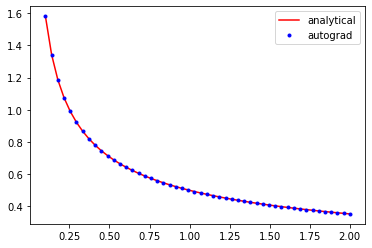

In [14]:
def f(x):
    return x**0.5


df = vmap(grad(f))  # This returns a callable function

x = np.linspace(0.1, 2)

import matplotlib.pyplot as plt

plt.plot(x, 0.5 * x**-0.5, "r-", x, df(x), "b.")
plt.legend(["analytical", "autograd"])
np.allclose(0.5 * x**-0.5, df(x))



AD is not magical, if a derivative is not defined, AD will not compute it. Here the derivative at x=0 is infinity, which is what jax reports.



In [15]:
df(np.array([0.0]))



DeviceArray([inf], dtype=float64)

The AD derivatives are identical within tolerance to the analytical
formula because autograd simply applies the chain rule to the program to
evaluate the derivatives.

**Limitation** Derivatives with integers is not well-defined since
integers are not continuous.

It might not seem like a big deal that this works. The significance
really shows when you have more complex programs. This Rube-Goldberg
program is equivalent to the previous program. You could work out the
derivative by the chain rule your self, but autograd has no problem
doing this through all the operations and loops!





DeviceArray(True, dtype=bool)

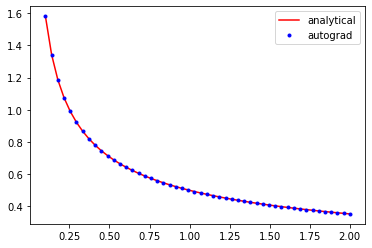

In [18]:
def f(x):
    a = 2.0 * x
    b = a**2
    c = b / 4.0
    d = c**0.5
    for i in range(5):
        d = d * 2

    for i in range(5):
        d = d / 2
        
    g = np.exp(d)
    h = np.log(g)

    e = np.sqrt(h)
    return e


df = vmap(grad(f))  # This returns a callable function

x = np.linspace(0.1, 2)

plt.plot(x, 0.5 * x**-0.5, "r-", x, df(x), "b.")
plt.legend(["analytical", "autograd"])
np.allclose(0.5 * x**-0.5, df(x))



Of course, autograd cannot make derivatives where they are not defined.
The derivative of the square root function is not defined at $x=0$, and
we get warnings and a `nan` result if we try to evaluate it there.





In [19]:
df(np.array([0.0]))



DeviceArray([nan], dtype=float64)

#### Derivatives of multivalue functions - Jacobian





Autograd really starts to shine when we have vector functions. If we
have a function that takes an input with $n$ and produces $m$ outputs,
then we frequently need to compute the derivatives of the output with
respect to the inputs. These are defined by:

$\mathbf{J}_{ij} = \frac{\partial f_i}{\partial x_j}$

jax provides functions for computing the Jacobian for this. Let's consider an
example:

$f_1(x, y) = x^2 y$

$f_2(x, y) = 5 x + \sin(y)$

The Jacobian of this system is:

\begin{equation} \left[\begin{array}{cc} 2 x y & x^2 \\ 5 & \cos y \\
\end{array}\right] \end{equation}

There are two Jacobian functions, `jacfwd` and `jacref`. In theory they do the same thing, but one of them will usually be faster for some systems. `jacfwd` uses a forward pass through the code to compute the Jacobian, while `jacrev` uses a reverse pass. The [documentation](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobians-and-hessians-using-jacfwd-and-jacrev) recommends using jacfwd for "tall" Jacobians and jacref for "wide" jacobians. For square jacobians, it does not matter. It is fine to be practical, and try both to see if one is faster than other.





In [22]:
from jax import jacfwd


def f(X):
    x, y = X
    return np.array([x**2 * y,              # f1
                     5 * x + np.sin(y)])    # f2


Jf = jacfwd(f)

# now show the equivalence
x, y = 0.5, 0.5
print("Jf: ", Jf(np.array([x, y])))  # use array for the input
print("An: ", np.array([[2 * x * y, x**2], 
                        [5,         np.cos(y)]]))

np.allclose(Jf(np.array([x, y])), np.array([[2 * x * y, x**2], [5, np.cos(y)]]))

Jf:  [[0.5        0.25      ]
 [5.         0.87758256]]
An:  [[0.5        0.25      ]
 [5.         0.87758256]]


DeviceArray(True, dtype=bool)

**Limitation** Note the explicit use of arrays in the above code. jax
requires you to use arrays explicitly most of the time, and you can get
errors if you are lazy and use lists/tuples.

We use Jacobians in a variety of applications, but one important one is
for changing variables in integrations, presumably because this results
in a simpler integral.

$\int \int_R f(x, y) dx dy = \int \int_{R'} f(x(u, v), y(u, v)) \left|\frac{\partial(x, y)}{\partial(u, v)}\right| du dv$

Where $\left|\frac{\partial(x, y)}{\partial(u, v)}\right|$ is defined as
the determinant of the Jacobian:

$\left|\begin{array}{cc} \frac{\partial x}{\partial u} & \frac{\partial x}{\partial v} \\ \frac{\partial y}{\partial u} & \frac{\partial y}{\partial v} \end{array}\right|$

Here is an example we work out that is adapted from:
[http://www.stat.rice.edu/~dobelman/notes_papers/math/Jacobian.pdf](http://www.stat.rice.edu/~dobelman/notes_papers/math/Jacobian.pdf)

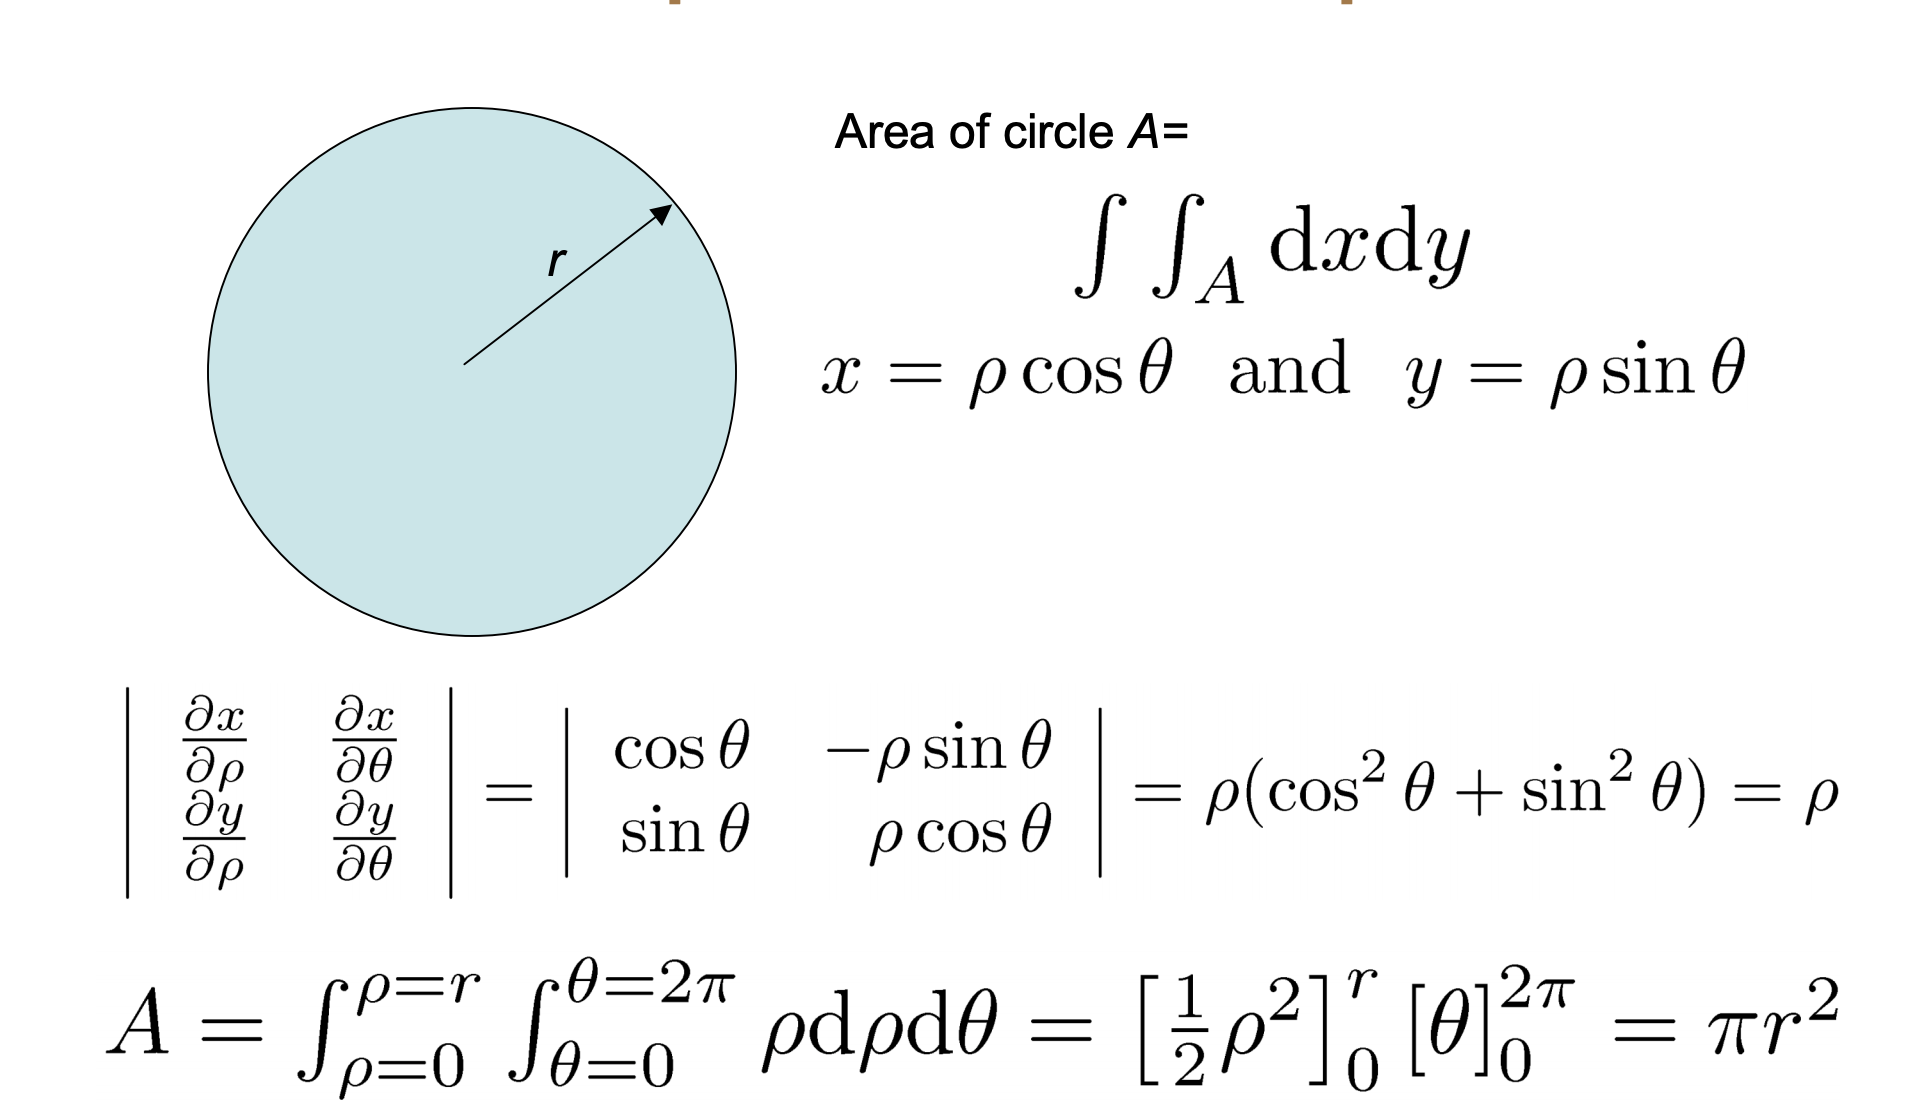

Executing that double integral in cartesian coordinates is not
convenient because the integral limits would be a function for $y$. If
we instead switch to polar coordinates, then we have the simpler limits
of $\rho$ from 0 to $r$, and $\theta$ from 0 to $2\pi$. There is no
$f(x, y)$ here, the integrand is just 1.

This is a double integral, and we use `scipy.integrate.dblquad`.





In [24]:
from scipy.integrate import dblquad

?dblquad



Signature: dblquad(func, a, b, gfun, hfun, args=(), epsabs=1.49e-08, epsrel=1.49e-08)
Docstring:
Compute a double integral.

Return the double (definite) integral of ``func(y, x)`` from ``x = a..b``
and ``y = gfun(x)..hfun(x)``.

Parameters
----------
func : callable
    A Python function or method of at least two variables: y must be the
    first argument and x the second argument.
a, b : float
    The limits of integration in x: `a` < `b`
gfun : callable or float
    The lower boundary curve in y which is a function taking a single
    floating point argument (x) and returning a floating point result
    or a float indicating a constant boundary curve.
hfun : callable or float
    The upper boundary curve in y (same requirements as `gfun`).
args : sequence, optional
    Extra arguments to pass to `func`.
epsabs : float, optional
    Absolute tolerance passed directly to the inner 1-D quadrature
    integration. Default is 1.49e-8. ``dblquad`` tries to obtain
    an accuracy of ``abs

Return the double (definite) integral of \`\`func(y, x)\`\` from \`\`x =
a..b\`\` and \`\`y = gfun(x)..hfun(x)\`\`.

We want:

$\int_{\rho=0}^{\rho=1} \int_{\theta=0}^{\theta=2\pi} det(J) d\rho d\theta = \pi$

That leads to this implementation:





In [25]:
def f(P):
    rho, theta = P
    return np.array([rho * np.cos(theta), rho * np.sin(theta)])  # x  # y


jf = jacfwd(f)


def integrand(rho, theta):
    J = jf(np.array([rho, theta]))
    return np.linalg.det(J)


# integrand(y, x)
xa, xb = 0, 2 * np.pi  # theta
ya, yb = 0, 1  # rho

dblquad(integrand, xa, xb, ya, yb)



(3.141592653589793, 3.487868498008632e-14)

And the expected answer. Compare that to the cartesian coordinate
system:

$\int_{-1}^1 \int_{-\sqrt{1 - x^2}}^{\sqrt{1 - x^2}} dx dy$





In [26]:
def integrand(y, x):
    return 1


def yl(x):
    return -np.sqrt(1 - x**2)


def yu(x):
    return np.sqrt(1 - x**2)


dblquad(integrand, -1, 1, yl, yu)



(3.1415926535897967, 2.000470900043183e-09)

The answer is the same, but the integral limits are more complex. Of
course, one can invoke Kitchin's conservation of complexity law here; we
can give up the complexity of the limits if we take on the complexity of
autograd.





#### Hessians





The [Hessian matrix](https://en.wikipedia.org/wiki/Hessian_matrix) is
a square matrix of second-order partial derivatives of a scalar-valued
function.

$\mathbf{H}_{ij} = \frac{\partial^2 f}{\partial x_i x_j}$

`jax.hessian` also returns a callable function.





In [33]:
from jax import hessian


def f(X):
    x, y = X
    return x**2 + y**2



H = hessian(f)

f([0.0, 0.0]), grad(f)([0.0, 0.0]), H(np.array([0.0, 0.0]))



(0.0,
 [DeviceArray(0., dtype=float64, weak_type=True),
  DeviceArray(0., dtype=float64, weak_type=True)],
 DeviceArray([[2., 0.],
              [0., 2.]], dtype=float64))

The Hessian is used to classify what kind of stationary points have been
found. It is also used in some optimization algorithms.





#### Applications to optimization





In [34]:
from scipy.optimize import minimize

?minimize



Signature:
minimize(
    fun,
    x0,
    args=(),
    method=None,
    jac=None,
    hess=None,
    hessp=None,
    bounds=None,
    constraints=(),
    tol=None,
    callback=None,
    options=None,
)
Docstring:
Minimization of scalar function of one or more variables.

Parameters
----------
fun : callable
    The objective function to be minimized.

        ``fun(x, *args) -> float``

    where ``x`` is a 1-D array with shape (n,) and ``args``
    is a tuple of the fixed parameters needed to completely
    specify the function.
x0 : ndarray, shape (n,)
    Initial guess. Array of real elements of size (n,),
    where ``n`` is the number of independent variables.
args : tuple, optional
    Extra arguments passed to the objective function and its
    derivatives (`fun`, `jac` and `hess` functions).
method : str or callable, optional
    Type of solver.  Should be one of

        - 'Nelder-Mead' :ref:`(see here) <optimize.minimize-neldermead>`
        - 'Powell'      :ref:`(see here) <

We will consider the
[Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), which has a minimum at (1, 1) with a value of 0. The
standard optimization approach is shown here for comparison.





In [35]:
from scipy.optimize import minimize


def rosenbrock(X):
    x, y = X
    return (1 - x) ** 2 + 100 * (y - x**2) ** 2


sol = minimize(rosenbrock, [1, 0])
print(sol)



      fun: 2.1116644640231938e-11
 hess_inv: array([[0.49382779, 0.98765393],
       [0.98765393, 1.98030451]])
      jac: array([-2.90006621e-07,  2.80646395e-08])
  message: 'Optimization terminated successfully.'
     nfev: 111
      nit: 32
     njev: 37
   status: 0
  success: True
        x: array([0.99999541, 0.9999908 ])


Next, we look at how to imporve the performance by providing the Jacobian and Hessian via AD functions.



In [ ]:
?minimize



The solution is pretty good, but we can get a better answer if we
provide the Jacobian. Usually you are expected to derive and implement
this. We do it in one like with jax. Since we have a scalar function, the Jacobian and grad are equivalent.





In [37]:
df = grad(rosenbrock)
df(np.array([1.0, 1.0]))



DeviceArray([0., 0.], dtype=float64)

In [38]:
df = grad(rosenbrock)

sol_j = minimize(rosenbrock, [1, 0], jac=df)
print(sol_j)



      fun: 1.929228336932511e-14
 hess_inv: array([[0.49289915, 0.98579551],
       [0.98579551, 1.97658546]])
      jac: array([-2.94106412e-07,  8.15714163e-09])
  message: 'Optimization terminated successfully.'
     nfev: 37
      nit: 32
     njev: 37
   status: 0
  success: True
        x: array([0.99999986, 0.99999972])


Note that the function is closer to zero (although it was small to start
with) and it took many fewer steps to get there.

Finally, we get an even better answer if we also provide the Hessian,
and use an algorithm that uses the Hessian (most of them do not).





In [ ]:
?minimize



In [39]:
hf = hessian(rosenbrock)
minimize(rosenbrock, [1, 0], jac=df, hess=hf, method="dogleg")



     fun: 4.930380657631324e-30
    hess: array([[ 802., -400.],
       [-400.,  200.]])
     jac: array([-8.8817842e-14,  4.4408921e-14])
 message: 'Optimization terminated successfully.'
    nfev: 2
    nhev: 1
     nit: 1
    njev: 2
  status: 0
 success: True
       x: array([1., 1.])

Note we get an almost exact answer, with only two function evaluations! 

You can see that the Hessian returned by this solver is identical to the
Hessian we would compute.





In [40]:
hf(np.array([1.0, 1.0]))



DeviceArray([[ 802., -400.],
             [-400.,  200.]], dtype=float64)

Note that in the example where we just provided the Jacobian that the
Hessian is approximated. You can see that here. It is pretty close, but
not exact.





In [41]:
print(np.linalg.inv(sol_j.hess_inv))



[[ 802.02588665 -399.99966532]
 [-399.99966532  200.00039681]]


### Summary





Today we reviewed computational approaches to taking derivatives. The
star of this lecture is automatic differentiation.

`jax` is very good, but it is worth spending some time reading https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html. It is not magic, and sometimes there are surprises that require innovative solutions.

Next time we will look at several applications of AD in calculus,
science and engineering. After that, we will return to nonlinear
regression and conclude with an introduction to machine learning.



